## SGD & Stochastic Gradient Langevin Dynamics (SGLD) predictions using Bayesian neural network
author: @karm-patel


**Resources:** 
1. https://github.com/jamesvuc/jax-bayes/blob/master/examples/deep/mnist/mnist_mcmc.ipynb
2. https://github.com/blackjax-devs/blackjax/blob/main/examples/SGLD.ipynb

In [1]:
import os

# to use specifoc GPU
# GPU_NO = 0
# os.environ['CUDA_VISIBLE_DEVICES']=str(GPU_NO)

# for latexified figures
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"

In [2]:
import jax
import jax.nn as nn
import jax.numpy as jnp
import numpy as np
from jax.flatten_util import ravel_pytree
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import flax
except ModuleNotFoundError:
    %pip install -qq flax
    import flax
from flax import linen as nn
from flax.core.frozen_dict import unfreeze

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    import tensorflow_probability.substrates.jax as tfp
except:
    %pip install -qq tensorflow_probability
    import tensorflow_probability.substrates.jax as tfp


try:
    import blackjax
except:
    %pip install -qq jaxopt blackjax
    import blackjax
from blackjax.sgmcmc.gradients import grad_estimator


try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds


try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

tfd = tfp.distributions

/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: LOCAL is an invalid version and will not be supported in a future release
  warnings.warn(


## Mnist Dataset

In [3]:
data = tfds.as_numpy(tfds.load("mnist:3.*.*", split="train", batch_size=-1))
X, y = data["image"], data["label"]

2022-07-08 16:03:20.340500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:
2022-07-08 16:03:20.340526: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# make mask for train-test split
rng_key = jax.random.PRNGKey(5)
test_size = 10000
data_size = len(X)
idx = jax.random.choice(key=rng_key, a=jnp.arange(data_size), shape=(test_size,), replace=False)
mask = np.repeat(False, data_size)
mask[idx] = True

In [5]:
X_test, y_test = X[mask], y[mask]
jnp.bincount(y_test)  # check if we have equal proportion of all labels

DeviceArray([ 963, 1119,  962, 1090,  917,  916, 1018, 1042,  997,  976], dtype=int32)

In [6]:
X_train, y_train = X[~mask], y[~mask]
jnp.bincount(y_train)

DeviceArray([4960, 5623, 4996, 5041, 4925, 4505, 4900, 5223, 4854, 4973], dtype=int32)

In [7]:
def prepare_data(dataset: tuple, num_categories=10, normalize=True):
    """
    preprocessing of data
    """
    X, y = dataset
    y = jax.nn.one_hot(y, num_categories)

    num_examples = X.shape[0]
    num_pixels = 28 * 28
    X = X.reshape(num_examples, num_pixels)
    if normalize:
        X = X / 255.0

    return jnp.array(X), jnp.array(y)

In [8]:
X_train, y_train = prepare_data((X_train, y_train))
X_train.shape, y_train.shape

((50000, 784), (50000, 10))

In [9]:
# if your RAM is exhausted with memory, then use 1000 samples from X_test as test data while doing predictions
X_test, y_test = prepare_data((X_test, y_test))
X_test.shape, y_test.shape

((10000, 784), (10000, 10))

In [10]:
# Batch the data
DATA_SIZE = len(data["label"])
BATCH_SIZE = 1_000
DATA_SIZE, BATCH_SIZE

(60000, 1000)

## Flax MLP model

In [11]:
nclasses = 10


class mlp(nn.Module):
    features: list
    activations: list

    @nn.compact
    def __call__(self, X, return_logits=False):
        if len(self.activations) != len(self.features) - 1:
            raise Exception(f"Length of activations should be equal to {len(self.features) - 1}")

        for i, feature in enumerate(self.features):
            X = nn.Dense(feature, name=f"{i}_Dense")(X)
            if i != len(self.features) - 1:
                X = self.activations[i](X)

        if return_logits:
            return X

        return nn.log_softmax(X)

    def sgd_loss(self, params, X, y):
        reg = 0.00001  # regularization constant
        labels = y

        log_probs = self.apply(params, X)
        softmax_crossent = -jnp.mean(labels * log_probs)

        l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
        return softmax_crossent + reg * l2_loss

    def compute_accuracy(self, parameters, X, y):
        """Compute the accuracy of the model.
        To make predictions we take the number that corresponds to the highest probability value.
        """
        target_class = jnp.argmax(y, axis=1)
        predicted_class = jnp.argmax(self.apply(parameters, X), axis=1)
        return jnp.mean(predicted_class == target_class)

In [12]:
def tree_shape(tree):
    """
    returns  shape of leaves of tree
    """
    return jax.tree_map(jnp.shape, tree)


def batch_data(rng_key, data, batch_size=BATCH_SIZE):
    """
    create batch from data of size batch_size
    """
    X, y = data
    idx = jax.random.choice(key=rng_key, a=jnp.arange(len(y)), shape=(batch_size,))
    batch = (X[idx], y[idx])
    return batch

## SGD

In [13]:
# create mlp model for SGD
rng_key = jax.random.PRNGKey(12)
features = [300, 100, 10]
activations = [nn.relu, nn.relu]
mlp_sgd = mlp(features, activations)
params = unfreeze(mlp_sgd.init(rng_key, X_train[:10]))  # params are forozendict so need to unfreeze to modify them
tree_shape(params)

{'params': {'0_Dense': {'bias': (300,), 'kernel': (784, 300)},
  '1_Dense': {'bias': (100,), 'kernel': (300, 100)},
  '2_Dense': {'bias': (10,), 'kernel': (100, 10)}}}

In [14]:
# set optimizer
learning_rate = 0.001
rmsprop_opt = optax.rmsprop(learning_rate)
opt_state = rmsprop_opt.init(params)  # initial state
grad_sgd_loss = jax.grad(mlp_sgd.sgd_loss)

In [15]:
@jax.jit
def train_step(carry, rng_key):
    params, opt_state = carry
    rng_key1, rng_key2 = jax.random.split(rng_key)
    X, y = batch_data(rng_key2, (X_train, y_train))

    grad_loss = grad_sgd_loss(params, X, y)
    updates, opt_state = rmsprop_opt.update(grad_loss, opt_state)
    params = optax.apply_updates(params, updates)
    loss = mlp_sgd.sgd_loss(params, X, y)

    accuracy_test = mlp_sgd.compute_accuracy(params, X_test, y_test)
    accuracy_train = mlp_sgd.compute_accuracy(params, X, y)

    return (params, opt_state), (accuracy_train, accuracy_test, loss)

In [16]:
%%time
carry = (params, opt_state)
(final_params_sgd, final_state), (accuracy_train, accuracy_test, loss) = jax.lax.scan(
    train_step, carry, jax.random.split(rng_key, 6000)
)

CPU times: user 6.92 s, sys: 3.09 s, total: 10 s
Wall time: 2.86 s


In [17]:
accuracy_train[-10:], accuracy_test[-10:]

(DeviceArray([1.       , 1.       , 1.       , 1.       , 0.9990001,
              1.       , 1.       , 0.9990001, 1.       , 0.9990001],            dtype=float32),
 DeviceArray([0.9783    , 0.97969997, 0.978     , 0.97789997, 0.97889996,
              0.97889996, 0.9783    , 0.9781    , 0.9773    , 0.9781    ],            dtype=float32))

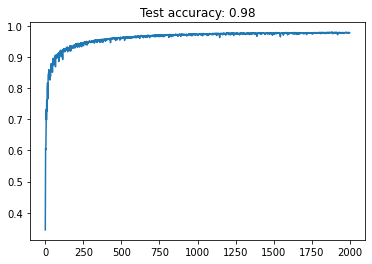

In [18]:
plt.plot(accuracy_test)
plt.title(f"Test accuracy: {accuracy_test[-10:].mean():.2f}");

In [19]:
# predictive probabilities
pred_probs = jnp.max(nn.softmax(mlp_sgd.apply(final_params_sgd, X_test, return_logits=True)), axis=1)
pred_probs.shape

(10000,)

In [20]:
def get_accuracy_vs_percentage_certainity_sgd(X, y, pred_probs, net_model, thresholds, params):
    pcts_sgd = []
    accs_sgd = []
    for th in thresholds:
        certain_mask = pred_probs >= th

        # accuracy
        accuracy = net_model.compute_accuracy(params, X[certain_mask], y[certain_mask])
        accs_sgd.append(accuracy)

        # percentage of certainity
        pct = jnp.mean(certain_mask)
        pcts_sgd.append(pct)

        print(pct, accuracy)

    return accs_sgd, pcts_sgd

In [21]:
thresholds = jnp.arange(0, 1.1, 0.1)
accs_sgd, pcts_sgd = get_accuracy_vs_percentage_certainity_sgd(
    X_test, y_test, pred_probs, mlp_sgd, thresholds, final_params_sgd
)

1.0 0.9781
1.0 0.9781
1.0 0.9781
1.0 0.9781
0.9995 0.9785893
0.99759996 0.97965115
0.9905 0.98283696
0.98149997 0.98553234
0.9726 0.98797035
0.95739996 0.99101734
0.095699996 1.0


In [22]:
def plot_accuracy_perc_certainity(ax, accs, pcts, thresholds, bbox=(0.8, 0.8), show_legend=True):
    ax_l = ax

    # plot perc_certainity
    ax_r = ax_l.twinx()
    pct_plot = ax_r.plot(thresholds, pcts, "-+", color="green", label="pct of certain preds")
    ax_r.set_ylabel("pct")
    ax_l.set_xlabel("certainty threshold")
    ax_r.set_ylim(0, 1.05)

    # plot accuracy
    acc_plot = ax_l.plot(thresholds, accs, "-+", label="Certainty Accuracy")
    ax_l.set_ylabel("accuracy")

    # plot accuracy on whole batch
    mn, mx = ax_r.get_xlim()
    acc_hline = ax_l.hlines(accs[0], mn, mx, color="black", linestyle="-.", label="Test accuracy")
    if show_legend:
        ax_r.legend(handles=[acc_plot[0], pct_plot[0], acc_hline], bbox_to_anchor=bbox, frameon=False)

    return ax_l, ax_r

/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


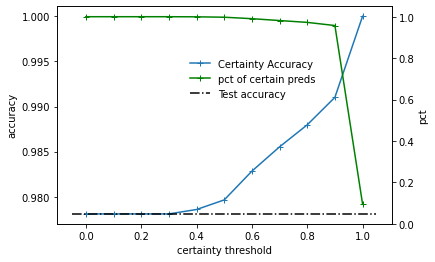

In [23]:
pml.latexify(width_scale_factor=2, fig_height=1.6)
fig, ax = plt.subplots()
plot_accuracy_perc_certainity(ax, accs_sgd, pcts_sgd, jnp.arange(0, 1.1, 0.1))
pml.savefig("acc-vs-conf-sgd")

## SGLD

In [24]:
def logprior_fn(params):
    flatten_params, unravel_fn = ravel_pytree(params)  # get all params in single array
    return jax.tree_map(lambda x: tfd.Normal(0, 1).log_prob(x), flatten_params).sum()

In [25]:
def loglikeli_fn(params, data):
    X_data, y_data = data
    pred_logprobs = mlp_sgld.apply(params, X_data)
    return jax.tree_map(lambda pred_logprob, y: pred_logprob * y, pred_logprobs, y_data).sum()

In [26]:
# crete MLP flax model
rng_key = jax.random.PRNGKey(28)
features = [300, 100, 10]
activations = [nn.softmax, nn.softmax]
mlp_sgld = mlp(features, activations)
params = unfreeze(mlp_sgld.init(rng_key, X_train[:10]))
tree_shape(params)

{'params': {'0_Dense': {'bias': (300,), 'kernel': (784, 300)},
  '1_Dense': {'bias': (100,), 'kernel': (300, 100)},
  '2_Dense': {'bias': (10,), 'kernel': (100, 10)}}}

In [27]:
# Build the SGLD kernel
step_size = 6e-4  # decrease this for better accuracy and smooth prediction
schedule_fn = lambda _: step_size  # constant step size
grad_fn = grad_estimator(logprior_fn, loglikeli_fn, data_size)
sgld = blackjax.sgld(grad_fn, schedule_fn)

In [28]:
%%time
# Set the initial state
rng_key = jax.random.PRNGKey(128)
init_positions = mlp_sgld.init(rng_key, X_train[:4])

X, y = batch_data(rng_key, (X_train, y_train))
state = sgld.init(init_positions, (X, y))

CPU times: user 2.81 s, sys: 119 ms, total: 2.93 s
Wall time: 6.35 s


In [29]:
@jax.jit
def inner_step(state, rng_key):
    """
    inner step will iterate 10 steps of training
    """
    _, rng_key2 = jax.random.split(rng_key)
    batch = batch_data(rng_key2, (X_train, y_train))
    state = sgld.step(rng_key, state, batch)
    return state, _


@jax.jit
def outer_step(state, rng_key):
    """
    outer step will store 10th sample & accuracy using that sample after each one complete iteration of inner step
    """

    # take sgld step n_samples times
    n_samples = 10
    keys = jax.random.split(rng_key, n_samples)
    state, _ = jax.lax.scan(inner_step, state, keys)
    params = state.position

    rng_key1, rng_key2 = jax.random.split(rng_key)

    # compute test accuracy
    test_acc = mlp_sgld.compute_accuracy(params, X_test, y_test)

    # compute train accuracy
    X, y = batch_data(rng_key2, (X_train, y_train))
    val_acc = mlp_sgld.compute_accuracy(params, X, y)

    return state, (state, val_acc, test_acc)

In [30]:
%%time
rng_key = jax.random.PRNGKey(47)
steps = 600  # but training loop (inner step) will iterate steps*n_samples time
final_state, (states, val_acc, test_acc) = jax.lax.scan(outer_step, state, jax.random.split(rng_key, steps))

CPU times: user 7.66 s, sys: 3.04 s, total: 10.7 s
Wall time: 3.24 s


In [31]:
val_acc[-10:], test_acc[-10:]

(DeviceArray([0.95600003, 0.93900007, 0.961     , 0.9480001 , 0.943     ,
              0.95600003, 0.95500004, 0.95400006, 0.938     , 0.95500004],            dtype=float32),
 DeviceArray([0.93979996, 0.9349    , 0.9414    , 0.9374    , 0.93479997,
              0.9411    , 0.9406    , 0.941     , 0.93539995, 0.9395    ],            dtype=float32))

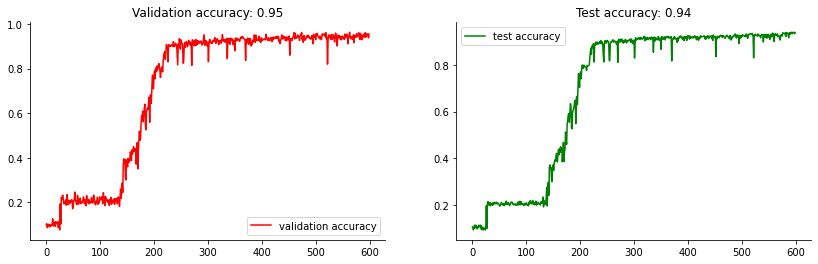

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(val_acc, "r", label="validation accuracy")
ax1.legend()
ax1.set_title(f"Validation accuracy: {jnp.mean(val_acc[-10:]):.2f}")

ax2.plot(test_acc, "g", label="test accuracy")
ax2.set_title(f"Test accuracy: {jnp.mean(test_acc[-10:]):.2f}")
ax2.legend()
sns.despine()

In [33]:
# remove warmup samples
params = states.position
num_warmup = 300
final_params_sgld = jax.tree_map(lambda x: x[num_warmup:], params)
tree_shape(final_params_sgld)

FrozenDict({
    params: {
        0_Dense: {
            bias: (300, 300),
            kernel: (300, 784, 300),
        },
        1_Dense: {
            bias: (300, 100),
            kernel: (300, 300, 100),
        },
        2_Dense: {
            bias: (300, 10),
            kernel: (300, 100, 10),
        },
    },
})

In [34]:
def sgld_posterior_predict(net_model, params_samples, X):
    """
    net_model: neaural net model for predictions
    params_sample: params of neural net sampled using MCMC
    X: data

    how to calculate posterior preds?
    .......
    Let n_samples_of_params = 5
    For given Xi:
        model_predicted_labels = [2, 2, 2, 8, 0]
        then,
        pred_prob (x1) = freq of most repeated labels / n_samles = 3/5

    returns
    .......
    posterior predictive probabilities of size len(X)
    """

    # predictive probabilities of X for each params
    # n_samples x len(X) x n_classes
    pred_probs = nn.softmax(jax.vmap(lambda param: net_model.apply(param, X, return_logits=True))(params_samples))

    # class predicted of X for each params
    # len(X) x n_samples
    predicted_class = jnp.argmax(pred_probs, axis=-1).T

    # number of params samples
    n_samples = predicted_class.shape[1]

    # posterior predictive probability using histogram
    posterior_pred_probs = jax.vmap(
        lambda pred_class_arr: (pred_class_arr == jnp.argmax(jnp.bincount(pred_class_arr, length=10))).mean()
    )(predicted_class)

    return posterior_pred_probs

In [35]:
posterior_pred_probs = sgld_posterior_predict(mlp_sgld, final_params_sgld, X_test)
posterior_pred_probs.shape

(10000,)

In [36]:
def get_accuracy_vs_percentage_certainity_sgld(X, y, posterior_pred_probs, net_model, thresholds, params_samples):
    thresholds = jnp.arange(0, 1.1, 0.1)
    pcts = []
    accs = []
    for th in thresholds:
        certain_mask = posterior_pred_probs >= th

        # accuracy
        if certain_mask.sum() == 0:
            acc_sample = 1
        else:
            acc_samples = jax.vmap(net_model.compute_accuracy, in_axes=(0, None, None))(
                params_samples, X[certain_mask], y[certain_mask]
            ).mean()
        accs.append(acc_samples)

        # percentage of certainty
        batch_size = len(posterior_pred_probs)
        pct = jnp.mean(certain_mask.mean())
        print(pct, acc_samples)
        pcts.append(pct)

    return accs, pcts

In [37]:
thresholds = jnp.arange(0, 1.1, 0.1)
accs_sgld, pcts_sgld = get_accuracy_vs_percentage_certainity_sgld(
    X_test, y_test, posterior_pred_probs, mlp_sgld, thresholds, final_params_sgld
)

1.0 0.92040634
1.0 0.92040634
1.0 0.92040634
0.9995 0.9207711
0.99439996 0.9239689
0.9798 0.9329346
0.95629996 0.94558614
0.93299997 0.9563945
0.9051 0.9683604
0.86139995 0.97970706
0.4529 0.9973504


/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


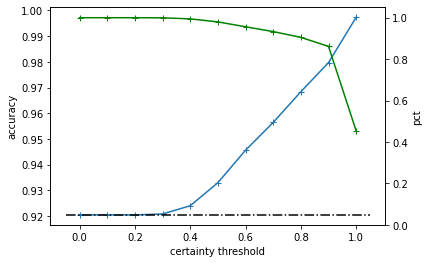

In [38]:
pml.latexify(width_scale_factor=2, fig_height=1.6)
fig, ax2 = plt.subplots()
plot_accuracy_perc_certainity(ax2, accs_sgld, pcts_sgld, jnp.arange(0, 1.1, 0.1), show_legend=False)
pml.savefig("acc-vs-conf-sgld")

## Distribution shift

In [39]:
fashion_ds = tfds.load("fashion_mnist:3.*.*", split="test").cache().repeat()
fashion_test_batches = tfds.as_numpy(fashion_ds.batch(10_000))
fashion_test_batches = iter(fashion_test_batches)
fashion_batch = next(fashion_test_batches)

In [40]:
X_fashion, y_fashion = prepare_data((fashion_batch["image"], fashion_batch["label"]))
X_fashion.shape, y_fashion.shape

((10000, 784), (10000, 10))

## SGD

In [41]:
pred_probs = jnp.max(nn.softmax(mlp_sgd.apply(final_params_sgd, X_fashion, return_logits=True)), -1)
pred_probs.shape

(10000,)

In [42]:
thresholds = jnp.arange(0, 1, 0.1)
accs_sgd_fash, pcts_sgd_fash = get_accuracy_vs_percentage_certainity_sgd(
    X_fashion, y_fashion, pred_probs, mlp_sgd, thresholds, final_params_sgd
)

1.0 0.086799994
1.0 0.086799994
1.0 0.086799994
0.99909997 0.08647783
0.9917 0.08631642
0.9709 0.084251724
0.93399996 0.08072805
0.89159995 0.078398384
0.83889997 0.07283347
0.7646 0.0661784


/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


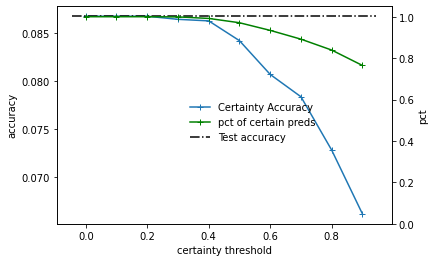

In [43]:
fig, ax1 = plt.subplots()

ax1_l, ax1_r = plot_accuracy_perc_certainity(ax1, accs_sgd_fash, pcts_sgd_fash, jnp.arange(0, 1, 0.1), bbox=(0.8, 0.6))
pml.savefig("acc-vs-conf-sgd-fashion")

## SGLD

In [44]:
posterior_pred_probs = sgld_posterior_predict(mlp_sgld, final_params_sgld, X_fashion)
posterior_pred_probs.shape

(10000,)

In [45]:
thresholds = jnp.arange(0, 1.1, 0.1)
accs_sgld_fash, pcts_sgld_fash = get_accuracy_vs_percentage_certainity_sgld(
    X_fashion, y_fashion, posterior_pred_probs, mlp_sgld, thresholds, final_params_sgld
)

1.0 0.057391662
1.0 0.057391662
1.0 0.057391662
0.9806 0.055688012
0.86289996 0.045777418
0.72609997 0.03393013
0.5959 0.024917493
0.4761 0.018405098
0.3579 0.013786906
0.2383 0.0102923475
0.021699999 0.0046082954


/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


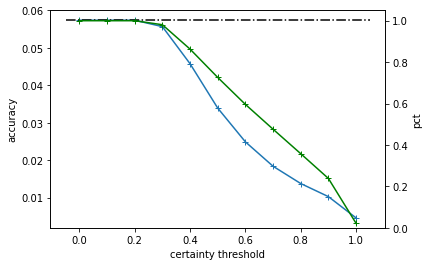

In [46]:
fig, ax1 = plt.subplots()

ax1_l, ax1_r = plot_accuracy_perc_certainity(
    ax1, accs_sgld_fash, pcts_sgld_fash, jnp.arange(0, 1.1, 0.1), show_legend=False
)
pml.savefig("acc-vs-conf-sgld-fashion")